# CMPE 351 Exercise 1

I'm choosing to get familiar with using VS Code for running Python and R for
data exploration. I'm deciding to stick with using just Python for this
exercise, using `pipenv` to manage my packages and virtual environments.

In [1]:
# Importing packages.
from os.path import dirname, join, realpath

# Data collection and processing
import pandas as pd

# Data visualization
import seaborn as sns
from scipy.stats import spearmanr

# Reading the data file relative to the current file, based on whther or not
# we're in a jupyter notebook or a script file, as I tend to edit code in
# script files to take advantage of linting and formatting.


def is_interactive():
    import __main__ as main

    return not hasattr(main, "__file__")


if is_interactive():
    script_dir = dirname(realpath("__file__"))
else:
    script_dir = dirname(realpath(__file__))

In [3]:
raw_listings_df = pd.read_csv(join(script_dir, "data/listings.csv"))
raw_listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,29059,Lovely studio Quartier Latin,125031,Maryline,NaN,Ville-Marie,45.51939,-73.56482,Entire home/apt,152,2,333,2020-03-15,2.82,2,323,4,NaN
1,29061,Maison historique - Quartier Latin,125031,Maryline,NaN,Ville-Marie,45.51929,-73.56493,Entire home/apt,286,3,82,2021-09-06,0.71,2,249,14,NaN
2,31847,Downtown/Airport room,2319,Gail,NaN,Le Sud-Ouest,45.48467,-73.57995,Private room,40,2,157,2019-10-02,1.37,3,255,4,NaN
3,34715,Chez Patrac ! Métro Beaubien,149769,Alain,NaN,Rosemont-La Petite-Patrie,45.53818,-73.60360,Entire home/apt,140,4,4,2011-09-12,0.03,1,214,0,261 026
4,36301,Romantic & peaceful Plateau loft,381468,Sylvie,NaN,Le Plateau-Mont-Royal,45.53026,-73.58413,Entire home/apt,130,31,42,2021-08-31,0.71,7,118,3,NaN


In [4]:
print(raw_listings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12333 entries, 0 to 12332
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              12333 non-null  int64  
 1   name                            12328 non-null  object 
 2   host_id                         12333 non-null  int64  
 3   host_name                       12331 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   12333 non-null  object 
 6   latitude                        12333 non-null  float64
 7   longitude                       12333 non-null  float64
 8   room_type                       12333 non-null  object 
 9   price                           12333 non-null  int64  
 10  minimum_nights                  12333 non-null  int64  
 11  number_of_reviews               12333 non-null  int64  
 12  last_review                     

## RQ1 (30 points)

> Provide at least three types of statistical summaries of the listing price
> ("price" column) in the data set. You can use plot or numeric values. Write
> a summary in the markdown cell, stating your finding(s) from your provided
> statistics summaries.

In [5]:
pricing_series = raw_listings_df["price"]

First, let's look at the Five-number summary to see the [markdown]
distribution of the listing prices.

In [6]:
print(pricing_series.describe())

count    12333.000000
mean       125.621747
std        261.253110
min          0.000000
25%         52.000000
50%         85.000000
75%        130.000000
max      13294.000000
Name: price, dtype: float64


It's clear that there are large outliers when looking that the [markdown]
3rd quartile and the maximum value. Let's look at a boxplot of the listing
prices to confirm this observation.

<AxesSubplot:xlabel='price'>

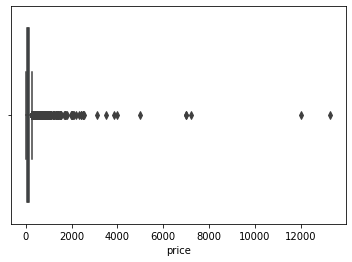

In [7]:
# Boxplot
sns.boxplot(x=pricing_series)

The abundant high value outliers make it difficult to observe [markdown]
the main part of the boxplot. Let's not show the outliers in another boxplot.

<AxesSubplot:xlabel='price'>

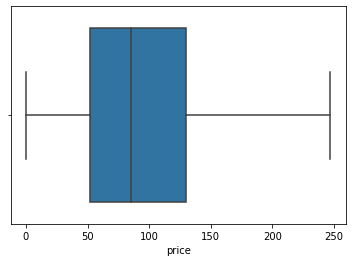

In [8]:
# Without the outliers
sns.boxplot(x=pricing_series, showfliers=False)

With a better idea of the outliers and the location of the data, let's now look at how spread out the data is and what shape it takes.

For the sake of visualization, we'll filter out the large valued outliers first.

In [9]:
# Source: https://datascience.stackexchange.com/a/57199/131303
first_quantile = pricing_series.quantile(0.25)
third_quantile = pricing_series.quantile(0.75)
interquantile_range = third_quantile - first_quantile
filter = (pricing_series > first_quantile - 1.5 * interquantile_range) & (
    pricing_series < third_quantile + 1.5 * interquantile_range
)

filtered_pricing_series = pricing_series[filter]

<AxesSubplot:xlabel='price', ylabel='Count'>

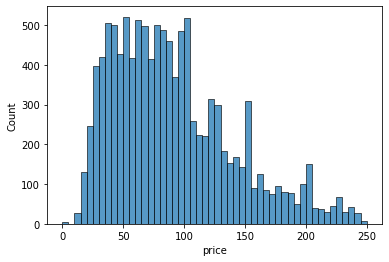

In [10]:
# Histogram
sns.histplot(filtered_pricing_series, binwidth=5)

<AxesSubplot:xlabel='price', ylabel='Density'>

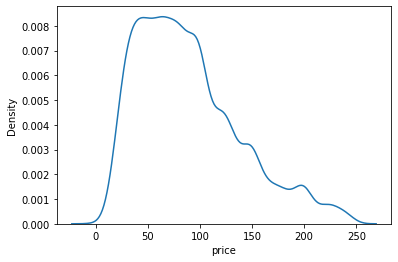

In [11]:
# Density plot
sns.kdeplot(filtered_pricing_series)

### Summary

The listing price data is spread out over a range of $0-$250, but has numerous outliers ranging from $250-$13 300. The shape of the listing price data is roughly a normal distribution that's slightly skewed to the right.

## RQ2 (20 points)

> Design and perform a statistical test involving list room
> type and list price. In a markdown cell, describe the null hypothesis
> statement of your test and why you choose a specific statistical test method.
> You can consider more attributes if you want.

Null hypothesis: Listing room type has no effect on listing price.
Alternative hypothesis: Listing room type has an effect on listing price.

Statistical test method: Spearman's Rank Correlation.
Reasoning: I want to test the relationship between a listing's room type and its price. Since there's no independent variable, and I can't assume that each room type has normally distributed prices, I decided to go with a non-parametric test.

<AxesSubplot:xlabel='room_type', ylabel='price'>

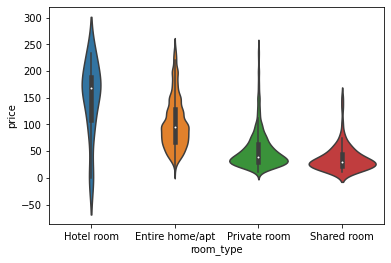

In [12]:
room_type_price_df = raw_listings_df[["room_type", "price"]][filter]
descending_median_order = (
    room_type_price_df.groupby(["room_type"])["price"]
    .median()
    .sort_values(ascending=False)
    .index
)

sns.violinplot(
    x="room_type",
    y="price",
    data=room_type_price_df,
    order=descending_median_order,
)

In [13]:
stat, p = spearmanr(
    room_type_price_df["room_type"], room_type_price_df["price"]
)

print("stat=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print("Fail to reject null hypothesis")
else:
    print("Reject null hypothesis")

stat=-0.523, p=0.000
Reject null hypothesis


## RQ3 (20 points)

> Design and perform a statistical test involving neighbourhood and list price.
> In a markdown cell, describe the null hypothesis statement of your test and
> why you choose a specific statistical test method.

Null hypothesis: Neighbourhood has no effect on listing price.
Alternative hypothesis: Neighbourhood has an effect on listing price.

Statistical test method: Spearman's Rank Correlation.
Reasoning: I want to test the relationship between a listing's neighbourhood and its price. Since there's no independent variable, and I can't assume that each room neighbourhood has normally distributed prices, I decided to go with a non-parametric test.

<AxesSubplot:xlabel='price', ylabel='neighbourhood'>

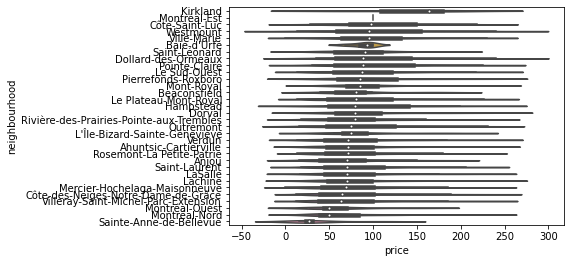

In [14]:
neighbourhood_price_df = raw_listings_df[["neighbourhood", "price"]][filter]
descending_median_order = (
    neighbourhood_price_df.groupby(["neighbourhood"])["price"]
    .median()
    .sort_values(ascending=False)
    .index
)

sns.violinplot(
    x="price",
    y="neighbourhood",
    data=neighbourhood_price_df,
    order=descending_median_order,
)

In [15]:
stat, p = spearmanr(
    neighbourhood_price_df["neighbourhood"], neighbourhood_price_df["price"]
)

print("stat=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print("Fail to reject null hypothesis")
else:
    print("Reject null hypothesis")

stat=0.099, p=0.000
Reject null hypothesis


## RQ4 (30 points)

> Design and perform at least two correlation analyses
> among attributes provided in the dataset. Describe why you believe it
> would be interesting to analyze the correlation between selected attributes.
> Write code and describe your main findings from the correlation analysis.

In [16]:
filtered_listings_df = raw_listings_df[filter]

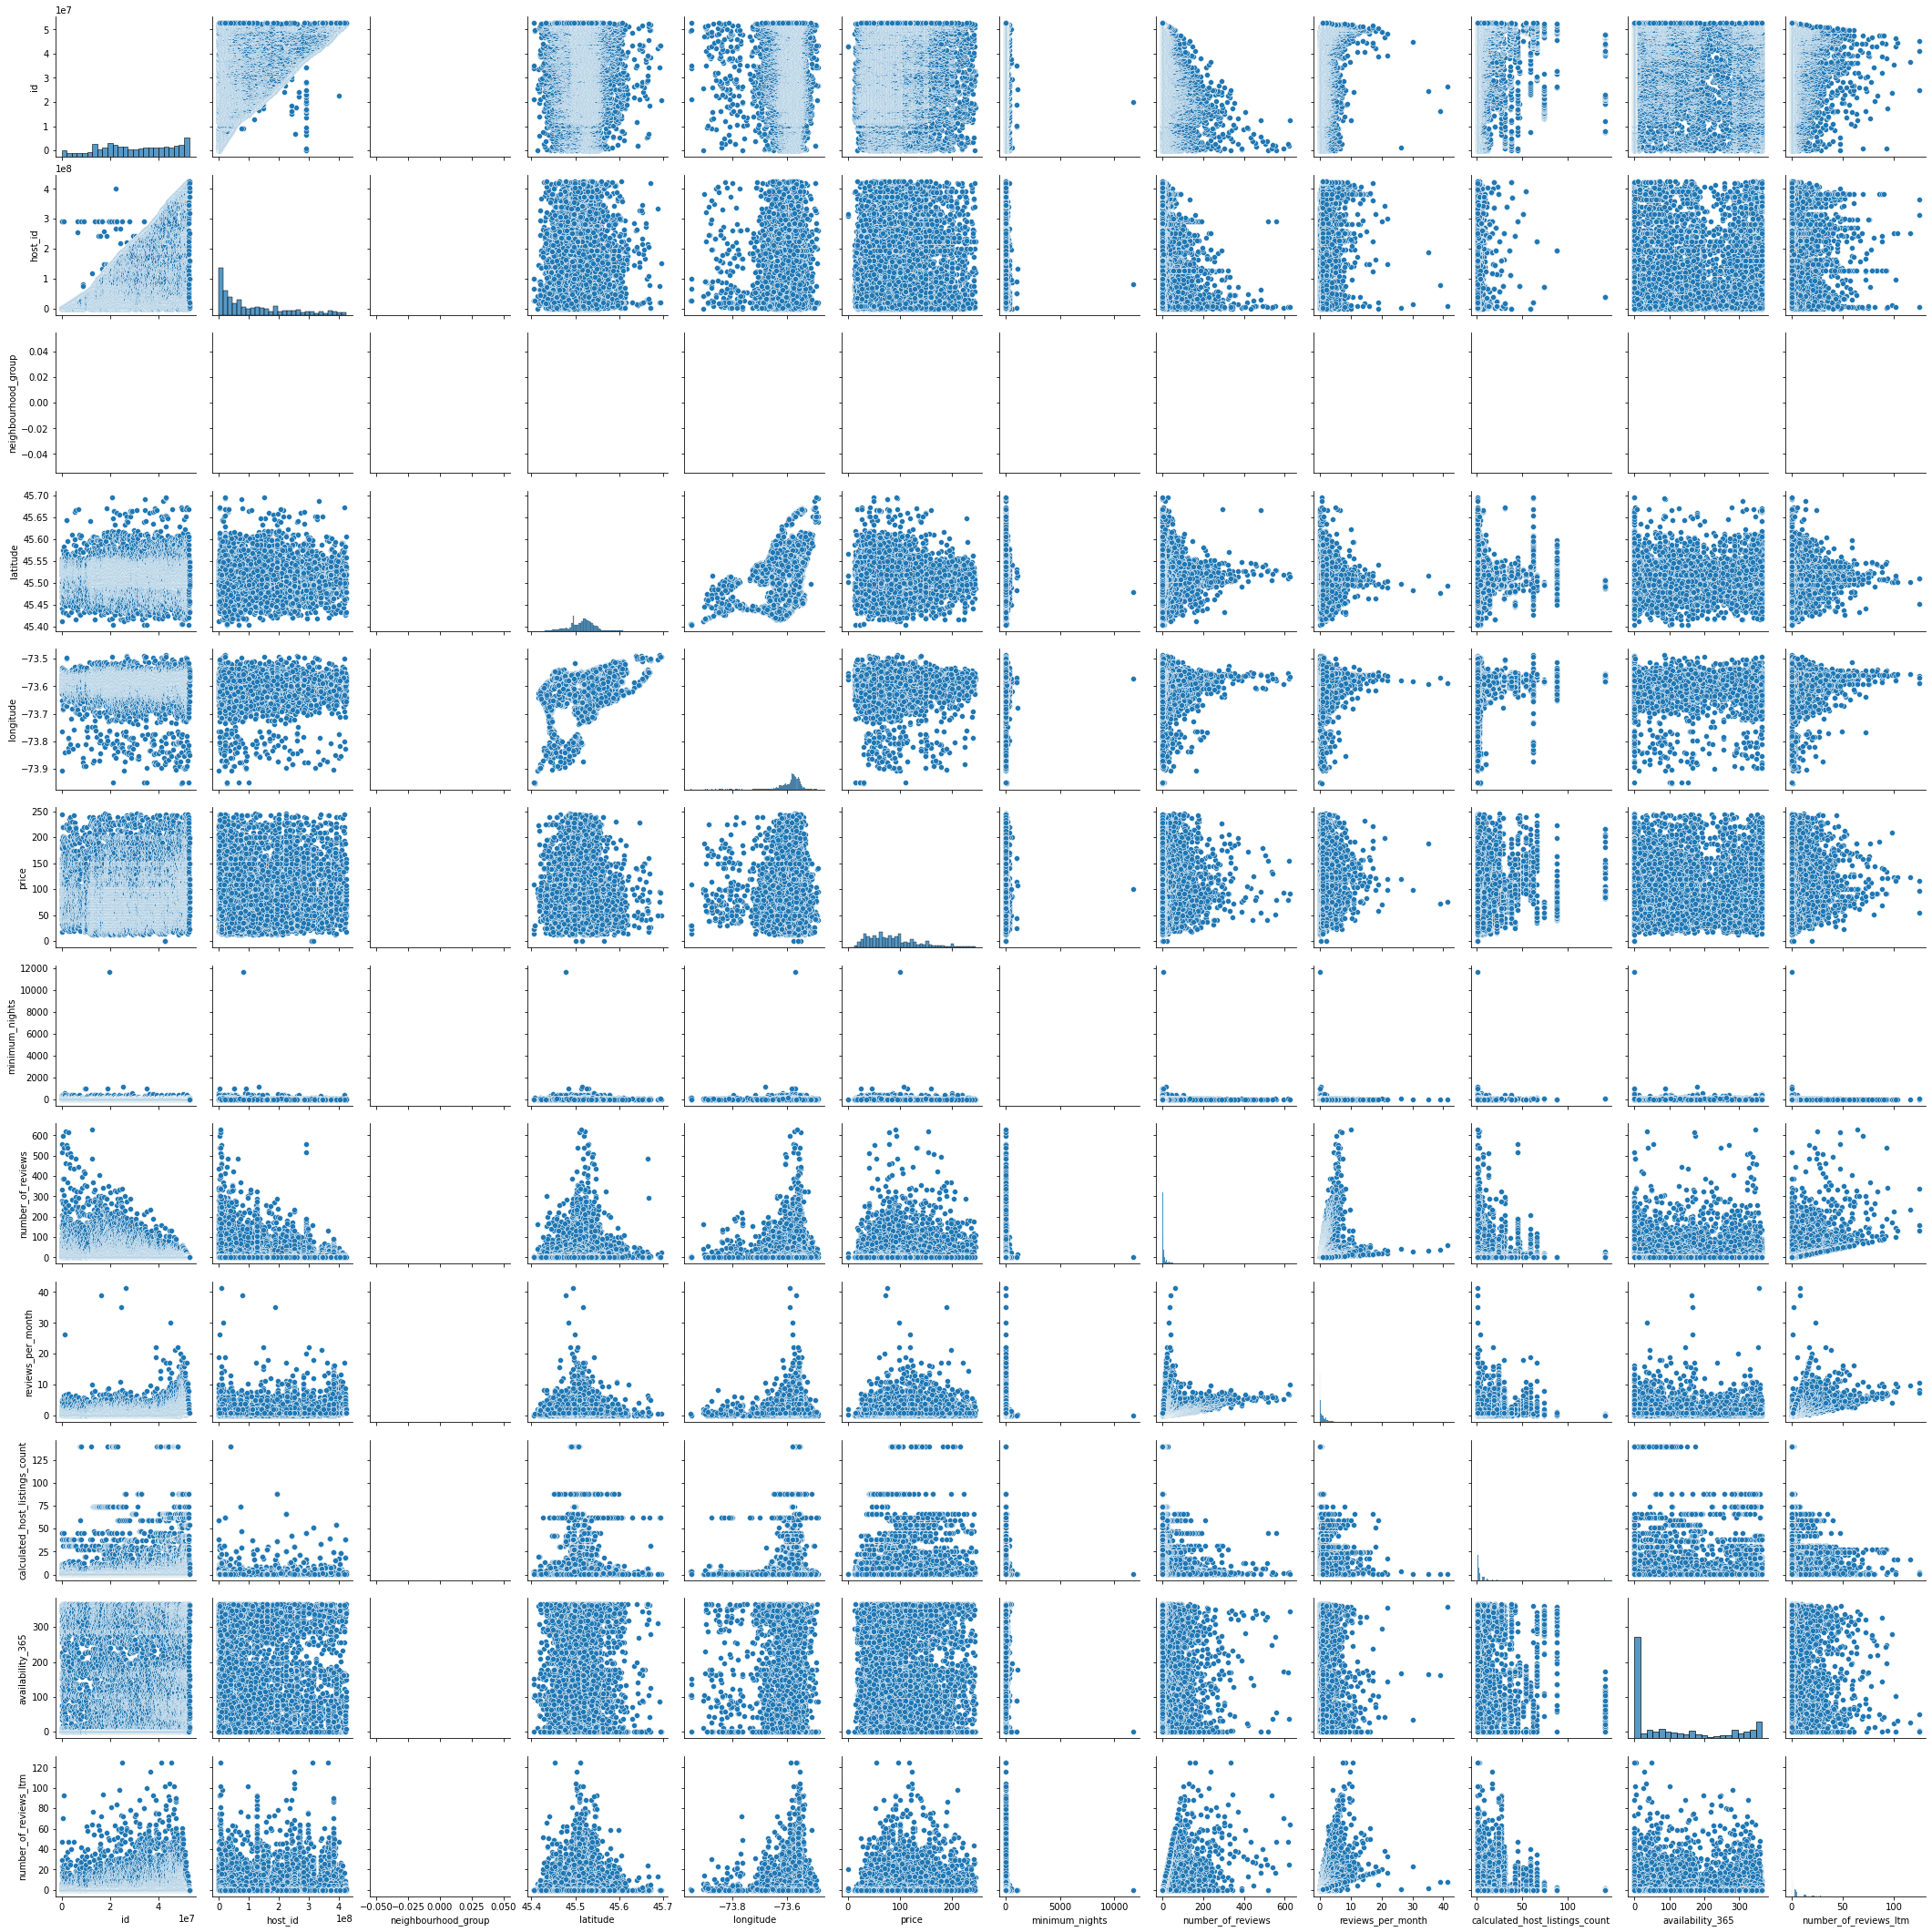

In [17]:
sns.pairplot(data=filtered_listings_df)

### Correlation between review count and calculated host listing count

Without access to review scores, seeing a correlation between a hosts's experience and the number of reviews their listings have could reveal some insight on people's reasons for leaving reviews based on their quality of listings from experienced hosts.

-0.04646212132762639


<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='number_of_reviews'>

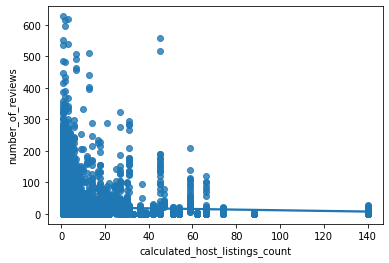

In [18]:
first_attribute = "calculated_host_listings_count"
second_attrbute = "number_of_reviews"
print(
    filtered_listings_df[first_attribute].corr(
        filtered_listings_df[second_attrbute]
    )
)
sns.regplot(data=filtered_listings_df, x=first_attribute, y=second_attrbute)

It's interesting seeing a slightly negative correlation between a listing's review count and host's listings count. Hosts with a higher listing count would imply that they have more experience being hosts, and thus have better quality listings. Without access to review score data, seeing that their listings tend to have lower review counts could imply that the listings are higher quality, and so not as many people review the listing to complain.

### Correlation between review count and price

Does having high review counts make the listing seem popular, thus implying a sense of demand that warrants a higher price?

0.10548814199299994


<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>

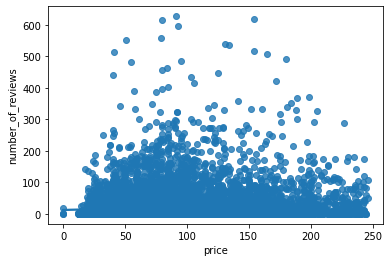

In [19]:
first_attribute = "price"
second_attrbute = "number_of_reviews"
print(
    filtered_listings_df[first_attribute].corr(
        filtered_listings_df[second_attrbute]
    )
)
sns.regplot(data=filtered_listings_df, x=first_attribute, y=second_attrbute)

The small positive correlation between a listing's review count and its price suggests that there are some hosts that set their prices higher based on the number of reviews their listings have. Although, it may also be a consequence of having more people live in the listings directly. In either case, one could say that host play a small game of economics (demand/price) based on their review count.